<a href="https://colab.research.google.com/github/MehmedJahanBakhsh/Streaming-Analytics-Project/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Dataset

In [4]:
 ! pip install -q kaggle

In [5]:
from google.colab import files

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammadjahanbakhsh7","key":"06c125db1cdc8b89ffe89766e3ab9d7a"}'}

In [7]:
! mkdir ~/.kaggle

In [8]:
cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          15996        464  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           5163        180  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           2036         96  1.0              
imoore/age-dataset                           

In [14]:
! kaggle datasets download 'eliasdabbas/web-server-access-logs'

 95% 253M/267M [00:08<00:00, 26.2MB/s]
100% 267M/267M [00:08<00:00, 33.6MB/s]


In [15]:
mkdir dataset

In [17]:
! unzip web-server-access-logs.zip -d dataset

Archive:  web-server-access-logs.zip
  inflating: dataset/access.log      
  inflating: dataset/client_hostname.csv  


Parsing logs and plotting load

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [20]:
# parse data to DataFrame

data_arr = []
with open('/content/dataset/access.log') as log:
    for line in log.readlines():
        match = re.match(r'(.+) - - \[(\d{2}\/\w{3}\/\d{4}:\d{2}:\d{2}:\d{2}) \+\d{4}\] \"(\w+) .+', line)
        if match:
            data_arr.append([match.group(1), match.group(2), match.group(3)])

data = pd.DataFrame(data_arr, columns=['ip_address', 'datetime', 'request_type'])

In [22]:
#Convert string datetime to Timestamp

data['datetime'] = data.datetime.apply(lambda x: x.replace('Jan', '01'))
data['datetime'] = pd.to_datetime(data.datetime, format='%d/%m/%Y:%H:%M:%S')

In [23]:
#add datetime columns to group by

data['day'] = data['datetime'].apply(lambda x: x.day)
data['hour'] = data['datetime'].apply(lambda x: x.hour)
data['minute'] = data['datetime'].apply(lambda x: x.minute)

In [24]:
#aggregate by minute and by hour

aggByMin = data.groupby(['day', 'hour', 'minute'], as_index=False).agg('count')\
  .rename({'ip_address': 'count'}, axis=1).drop(['datetime', 'request_type'], axis=1)

aggByHour = data.groupby(['day', 'hour'], as_index=False).agg('count')\
  .rename({'ip_address': 'count'}, axis=1).drop(['datetime', 'request_type', 'minute'], axis=1)

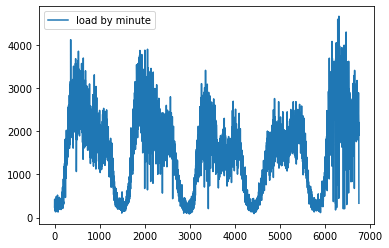

In [25]:
#plot it

plt.plot(aggByMin['count'], label='load by minute')
plt.legend()

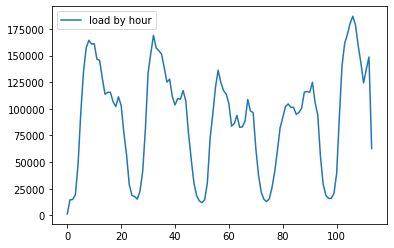

In [26]:
plt.plot(aggByHour['count'], label='load by hour')
plt.legend()

ARIMA